In [1]:
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Input,Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.regularizers import l2
from sklearn.model_selection import KFold

In [2]:
# Đọc file CSV
df = pd.read_csv('labeled_images.csv')

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


# In ra một số thông tin về dữ liệu đã chia
print("Số lượng mẫu trong tập huấn luyện:", len(train_df))
print("Số lượng mẫu trong tập kiểm tra:", len(test_df))


Số lượng mẫu trong tập huấn luyện: 1535
Số lượng mẫu trong tập kiểm tra: 384


In [3]:
def resize_image(image, target_size):
    return cv2.resize(image, target_size)

def convert_to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def adjust_brightness(image):
    if len(image.shape) == 2:  # Nếu ảnh đơn kênh (grayscale)
        return cv2.equalizeHist(image)

def remove_noise(image, ksize=5):
    return cv2.GaussianBlur(image, (ksize, ksize), 0)

def normalize_image(image):
    return image / 255.0

def handle_missing_values(image):
    if np.any(np.isnan(image)):
        image = np.nan_to_num(image)
    return image

def sharpen_image(image, sigma=1.0, strength=1.5):
    blurred = cv2.GaussianBlur(image, (0, 0), sigma)
    sharpened_image = cv2.addWeighted(image, 1.0 + strength, blurred, -strength, 0)
    return sharpened_image




In [4]:
def preprocess_image(image, target_size=(200, 200)):
       
    # Resize image
    image = resize_image(image, target_size)
    
    # Convert to grayscale
    image = convert_to_grayscale(image)
    
    # Adjust brightness
    image = adjust_brightness(image)
    
    # Remove noise
    image = remove_noise(image)
    
    # Handle missing values
    image = handle_missing_values(image)
    
    # Sharpen image
    image = sharpen_image(image)
    
    # Normalize image
    image = normalize_image(image)
    
    # Thêm kênh cho ảnh xám
    image = np.expand_dims(image, axis=-1)
    
    return image



In [5]:
# Tách dữ liệu đầu vào và nhãn từ DataFrame
def create_dataset(df):
    # Khởi tạo danh sách dữ liệu đầu vào (X) và nhãn (y)
    X = []
    y = []

    # Duyệt qua từng hàng trong DataFrame
    for _, row in df.iterrows():
        image_path = "data/Final_data/" + row[0]  # Thêm đường dẫn đến thư mục chứa ảnh
        label = row[1]  # Sử dụng cột thứ hai làm nhãn
        

        # Đọc ảnh từ đường dẫn
        image = cv2.imread(image_path)
        
        # Kiểm tra xem việc đọc ảnh có thành công không
        if image is None:
            print(f"WARNING: Failed to read image from {image_path}. Skipping...")
            continue

        # Tiền xử lý ảnh
        image = preprocess_image(image)

        # Thêm ảnh vào danh sách dữ liệu đầu vào
        X.append(image)
        # Thêm nhãn vào danh sách nhãn
        y.append(label)

    # Chuyển đổi danh sách thành numpy arrays
    X = np.array(X)
    y = np.array(y)

    return X, y




In [6]:
# Đường dẫn tới thư mục chứa ảnh gốc
final_folder_path = 'data/Final_data'

# Tạo dữ liệu đầu vào và nhãn cho tập huấn luyện và tập kiểm tra
X_train, y_train = create_dataset(train_df)
X_test, y_test = create_dataset(test_df)

# Kiểm tra kích thước của dữ liệu đầu vào và nhãn
print("Kích thước của tập huấn luyện - X:", X_train.shape, "y:", y_train.shape)
print("Kích thước của tập kiểm tra - X:", X_test.shape, "y:", y_test.shape)

C:\Users\dovie\AppData\Local\Temp\ipykernel_7300\3267775187.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_path = "data/Final_data/" + row[0]  # Thêm đường dẫn đến thư mục chứa ảnh
C:\Users\dovie\AppData\Local\Temp\ipykernel_7300\3267775187.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[1]  # Sử dụng cột thứ hai làm nhãn


Kích thước của tập huấn luyện - X: (1535, 200, 200, 1) y: (1535,)
Kích thước của tập kiểm tra - X: (384, 200, 200, 1) y: (384,)


In [7]:
label_train = y_train
label_test = y_test

y_train = np.array(y_train)
y_test = np.array(y_test)
encoder = OneHotEncoder()
encoder.fit(y_train.reshape(-1,1))
y_train = encoder.transform(y_train.reshape(-1,1)).toarray()
y_test = encoder.transform(y_test.reshape(-1,1)).toarray()

In [8]:
print("Kích thước của tập huấn luyện - X:", X_train.shape, "y:", y_train.shape)
print("Kích thước của tập kiểm tra - X:", X_test.shape, "y:", y_test.shape)

Kích thước của tập huấn luyện - X: (1535, 200, 200, 1) y: (1535, 4)
Kích thước của tập kiểm tra - X: (384, 200, 200, 1) y: (384, 4)


PCA giảm chiều dữ liệu

In [9]:
import mglearn
from sklearn.decomposition import PCA
# mglearn.plots.plot_pca_illustration()

In [10]:
#We reshape images for machine learnig  model
data_train_df = X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
print("X shape:",data_train_df.shape)

data_test_df = X_test.reshape((X_test.shape[0],X_test.shape[1]*X_test.shape[2]))
print("X test shape:",data_test_df.shape)


X shape: (1535, 40000)
X test shape: (384, 40000)


In [11]:
# Giảm chiều dữ liệu
from sklearn.decomposition import PCA

n_components = 90

pca=PCA(n_components=n_components, whiten=True)
pca.fit(data_train_df)

X_train_pca=pca.transform(data_train_df)
X_test_pca=pca.transform(data_test_df)

In [12]:
from sklearn.svm import SVC
from sklearn.metrics import log_loss, accuracy_score

In [46]:
# Cross_Validation 
# Số lượng fold
n_folds = 5

# Tạo đối tượng KFold
kf = KFold(n_splits=n_folds)

# Khởi tạo danh sách để lưu trữ loss và accuracy của từng fold
losses = []
accuracies = []

# Lặp qua từng fold
for train_index, val_index in kf.split(X_train_pca):
    # Tạo dữ liệu huấn luyện và kiểm định cho fold hiện tại
    X_train_fold, X_val_fold = X_train_pca[train_index], X_train_pca[val_index]
    y_train_fold, y_val_fold = label_train[train_index], label_train[val_index]

    clf = SVC(probability=True)  # Đặt probability=True để tính toán xác suất
    clf.fit(X_train_fold, y_train_fold)

    # Đánh giá mô hình
    decision_values = clf.decision_function(X_val_fold)
    y_pred_proba = 1 / (1 + np.exp(-decision_values))  # Sử dụng hàm sigmoid
    loss = log_loss(y_val_fold, y_pred_proba)  # Tính loss
    accuracy = accuracy_score(y_val_fold, clf.predict(X_val_fold))  # Tính accuracy

    losses.append(loss)
    accuracies.append(accuracy)

    print("Fold {}: loss test: {:.4f}, accuracy test: {:.4f}".format(len(losses), loss, accuracy))

# Tính trung bình loss và accuracy trên tất cả các fold
avg_loss = sum(losses) / len(losses)
avg_accuracy = sum(accuracies) / len(accuracies)

print("\nAverage loss: {:.4f}".format(avg_loss))
print("Average accuracy: {:.4f}".format(avg_accuracy))

c:\Users\dovie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Fold 1: loss test: 1.1456, accuracy test: 0.9609


c:\Users\dovie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Fold 2: loss test: 1.1326, accuracy test: 0.9935


c:\Users\dovie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Fold 3: loss test: 1.1341, accuracy test: 0.9870


c:\Users\dovie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Fold 4: loss test: 1.1357, accuracy test: 0.9707
Fold 5: loss test: 1.1335, accuracy test: 0.9935

Average loss: 1.1363
Average accuracy: 0.9811


c:\Users\dovie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


In [13]:
# Train SVC
clf = SVC()
clf.fit(X_train_pca, label_train)
y_pred_test = clf.predict(X_test_pca)
print("accuracy score test:{:.2f}".format(accuracy_score(label_test, y_pred_test)))

accuracy score test:0.98


In [18]:
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns

In [16]:
print(classification_report(label_test,y_pred_test))

              precision    recall  f1-score   support

           1       0.91      1.00      0.95        90
           2       1.00      1.00      1.00        99
           3       1.00      0.97      0.99       105
           4       1.00      0.93      0.97        90

    accuracy                           0.98       384
   macro avg       0.98      0.98      0.98       384
weighted avg       0.98      0.98      0.98       384



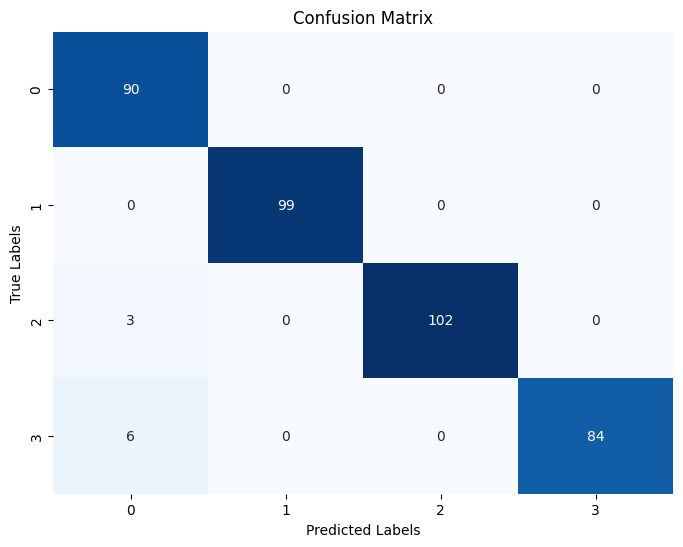

In [19]:
# Tính toán ma trận nhầm lẫn (confusion matrix)
cm = confusion_matrix(label_test, y_pred_test)

# Vẽ biểu đồ nhiệt
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


CNN model

In [57]:
#Cross Validation
# Số lượng fold
n_folds = 5

# Tạo đối tượng KFold
kf = KFold(n_splits=n_folds)

# Lặp qua từng fold
for train_index, val_index in kf.split(X_train):
    # Tạo dữ liệu huấn luyện và kiểm định cho fold hiện tại
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Tạo mô hình
    inp = Input(shape = (200,200,1)) #input shape
    cnn = Conv2D(filters = 8, kernel_size = 3, activation = 'relu')(inp)
    pooling = MaxPooling2D(pool_size = (2,2))(cnn)
    drop = Dropout(0.2)(pooling)

    cnn = Conv2D(filters = 16, kernel_size = 4,activation = 'relu') (drop)
    pooling = MaxPooling2D(pool_size = (2,2))(cnn)
    drop = Dropout(0.3)(pooling)

    cnn = Conv2D(filters = 32, kernel_size = 4,activation = 'relu') (drop)
    pooling = MaxPooling2D(pool_size = (2,2))(cnn)

    f = Flatten()(pooling)

    fc1 = Dense(units = 32, activation = 'relu', kernel_regularizer=l2(0.01)) (f)
    fc2 = Dense(units = 16, activation = 'relu') (fc1)
    out = Dense(units = 4, activation = 'softmax') (fc2)  # Sửa ở đây: thay 4 bằng 5

    model = Model(inputs = inp, outputs = out)

    # Biên dịch mô hình
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Huấn luyện mô hình
    model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32)

    # Đánh giá mô hình
    score = model.evaluate(X_val_fold, y_val_fold)

    print('Score for fold: ', score)

Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.6695 - loss: 1.2352
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.9599 - loss: 0.3821
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.9777 - loss: 0.2213
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.9857 - loss: 0.1645
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.9861 - loss: 0.1548
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.9794 - loss: 0.1308
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.9874 - loss: 0.1067
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.9919 - loss: 0.0995
Epoch 9/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.9866 - loss: 0.1119
Epoch 10/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.9847 - loss: 0.1057
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9475 - loss: 0.1996
Score for fold:  [0.18611927330493927, 0.9641693830490112]
Epoch 1/10
39/39

In [12]:
# Train Model
# Relu giu nguyen gia tri duong chuyen gia tri am thanh 0
inp = Input(shape = (200,200,1)) #input shape
cnn = Conv2D(filters = 8, kernel_size = 3, activation = 'relu')(inp)
pooling = MaxPooling2D(pool_size = (2,2))(cnn)


cnn = Conv2D(filters = 16, kernel_size = 4,activation = 'relu') (pooling)
pooling = MaxPooling2D(pool_size = (2,2))(cnn)


cnn = Conv2D(filters = 32, kernel_size = 4,activation = 'relu') (pooling)
pooling = MaxPooling2D(pool_size = (2,2))(cnn)

f = Flatten()(pooling)

fc1 = Dense(units = 32, activation = 'relu') (f)
fc2 = Dense(units = 16, activation = 'relu') (fc1)
out = Dense(units = 4, activation = 'softmax') (fc2)

model = Model(inputs = inp, outputs = out)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200, 200, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 198, 198, 8)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 99, 99, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 96, 96, 16)     │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 45, 45, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       495,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 506,612 (1.93 MB)

 Trainable params: 506,612 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
optimizer1 = tensorflow.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer1, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.5586 - loss: 1.1784 - val_accuracy: 0.9167 - val_loss: 0.4804
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9473 - loss: 0.3498 - val_accuracy: 0.9740 - val_loss: 0.1474
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.9703 - loss: 0.1242 - val_accuracy: 0.9792 - val_loss: 0.0898
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.9746 - loss: 0.0840 - val_accuracy: 0.9818 - val_loss: 0.0720
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.9811 - loss: 0.0681 - val_accuracy: 0.9818 - val_loss: 0.0619
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.9885 - loss: 0.0460 - val_accuracy: 0.9870 - val_loss: 0.0529
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.9925 - loss: 0.0364 - val_accuracy: 0.9870 - val_loss: 0.0403
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.9868 - loss: 0.0365 - val_accuracy: 0.9870 - v

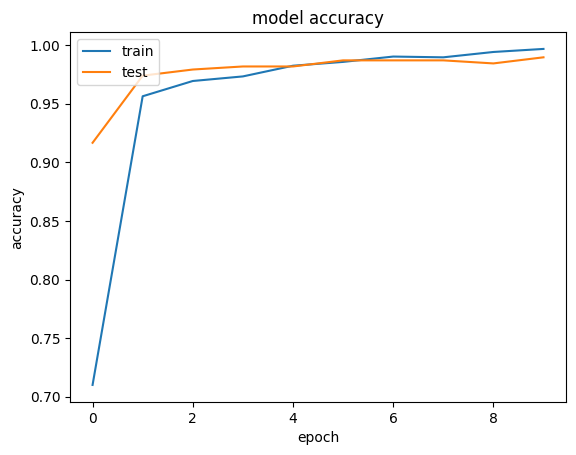

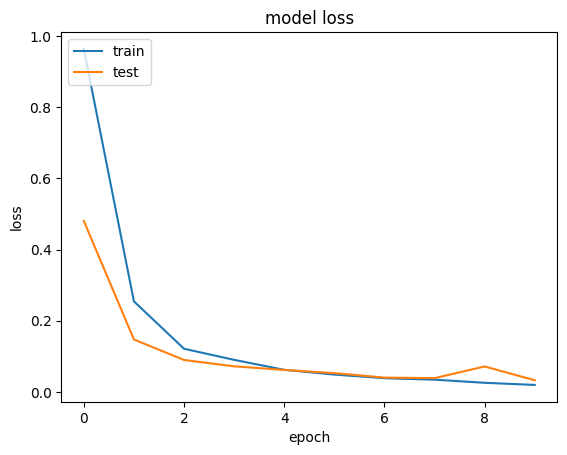

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc = 'upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc = 'upper left')
plt.show()

In [15]:
model.save('model1.h5')